Example of Object Detection with Detectron 2 based on the tutorial from:

https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5#scrollTo=b2bjrfb2LDeo


------------ Environment Setup ------------------

This was ran on a Standard NV6_Promo (6 vcpus, 56 GiB memory) Instance on Azure which includes GPU's

Requirements:

Python 3.6<br>GPU - cuda-drivers (418.87.00-1)

Step 1 - The Cuda Driver on the Istance is not up-to-date, so an update is requrired to the NV6_Promo instance (as of 2019-01-01)

To update the Cuda Driver issue the following command:

sudo apt-get install cuda-drivers

A Reboot of the linux host is then required:

sudo reboot

Step 2 - Install the python libraries for Detectron 2

cd /data/anaconda/envs/py36/bin <br>
./pip install torch==1.3.0+cu92 torchvision==0.4.1+cu92 -f https://download.pytorch.org/whl/torch_stable.html <br>
./pip install git+https://github.com/facebookresearch/fvcore.git <br>
git clone https://github.com/facebookresearch/detectron2 detectron2_repo <br>
./pip install -e detectron2_repo <br>
./pip install 'git+https://github.com/facebookresearch/fvcore' <br>
./pip install opencv-python <br>
./pip install "git+https://github.com/philferriere/cocoapi.git#egg=pycocotools&subdirectory=PythonAPI" <br>

If using Jupyter a restat of the kernel is necessary for the notebook to the new packages

Create Cell Dataset which will be used to for object detection, also create a project specific instance of the detectron2_repo by running the output of the next cell in the linux command line<br>

In [1]:
import os
dirpath = os.getcwd()
print("cd %s" % dirpath)
print("git clone https://github.com/facebookresearch/detectron2 detectron2_repo")

cd /data/home/ben_dk_ds/notebooks/hw
git clone https://github.com/facebookresearch/detectron2 detectron2_repo


Need to unzip files on first pass

In [2]:
#import zipfile
#with zipfile.ZipFile("cell_obj_detection_images.zip", 'r') as zip_ref:
#    zip_ref.extractall("./")

In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
%matplotlib inline

In [4]:
# write a function that loads the dataset into detectron2's standard format
def get_cell_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for _, v in imgs_anns.items():
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            assert not anno["region_attributes"]
            anno = anno["shape_attributes"]
            px = anno["all_points_x"]
            py = anno["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = list(itertools.chain.from_iterable(poly))

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [5]:
source_dir = "upload/"
train_dir = "%strain" % source_dir
valid_dir = "%svalid" % source_dir
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "valid"]:
    DatasetCatalog.register(source_dir + d, lambda d=d: get_cell_dicts(source_dir + d))
    MetadataCatalog.get(source_dir + d).set(thing_classes=["cell"])
cell_metadata = MetadataCatalog.get(train_dir)

In [6]:
dataset_dicts = get_cell_dicts(train_dir)

Populating the interactive namespace from numpy and matplotlib
upload/valid/p232_0_A06F00d2.jpg


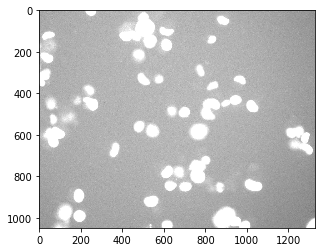

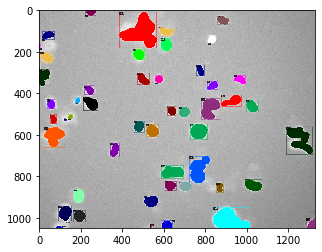

upload/valid/p388_0_A04F00d2.jpg


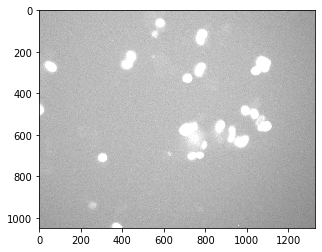

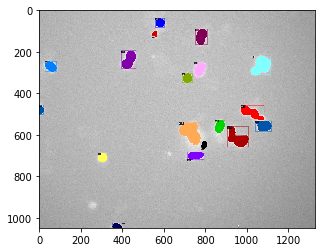

upload/valid/p544_0_A04F00d2.jpg


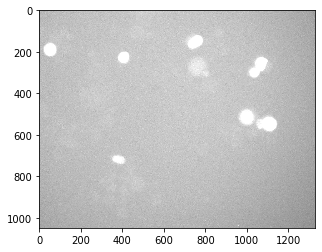

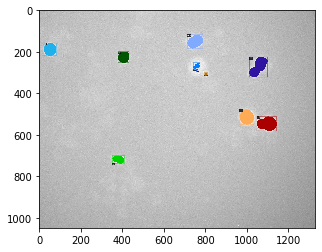

In [7]:
%pylab inline
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

dataset_dicts = get_cell_dicts(valid_dir)
for d in random.sample(dataset_dicts, 3):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    implot = plt.imshow(img)
    plt.show()
    visualizer = Visualizer(img[:, :, ::-1], metadata=cell_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    imgplot = plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

In [20]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = (train_dir,)
cfg.DATASETS.TEST = () # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 3
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (cell)
cfg.MODEL.MASK_ON = True

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

WARNING [11/24 21:25:13 d2.config.compat]: Config './detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[11/24 21:25:14 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
    

[11/24 21:25:21 d2.data.build]: Removed 0 images with no usable annotations. 99 images left.
[11/24 21:25:21 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[11/24 21:25:21 d2.data.build]: Using training sampler TrainingSampler


'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (2, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (4, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.
'roi_heads.mask_head.predictor.weight' has shape (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in the model! Skipped.
'roi_heads.mask_head.predictor.bias' has shape (80,) in the checkpoint but (1,) in the model! Skipped.


[11/24 21:25:22 d2.engine.train_loop]: Starting training from iteration 0
[11/24 21:25:45 d2.utils.events]: eta: 0:09:24  iter: 19  total_loss: 5.742  loss_cls: 0.659  loss_box_reg: 0.634  loss_mask: 0.690  loss_rpn_cls: 3.072  loss_rpn_loc: 0.620  time: 1.1619  data_time: 0.0365  lr: 0.000005  max_mem: 3792M
[11/24 21:26:08 d2.utils.events]: eta: 0:08:56  iter: 39  total_loss: 3.520  loss_cls: 0.614  loss_box_reg: 0.675  loss_mask: 0.683  loss_rpn_cls: 0.935  loss_rpn_loc: 0.590  time: 1.1527  data_time: 0.0311  lr: 0.000010  max_mem: 3792M
[11/24 21:26:30 d2.utils.events]: eta: 0:08:24  iter: 59  total_loss: 2.659  loss_cls: 0.575  loss_box_reg: 0.689  loss_mask: 0.670  loss_rpn_cls: 0.150  loss_rpn_loc: 0.535  time: 1.1381  data_time: 0.0300  lr: 0.000015  max_mem: 3792M
[11/24 21:26:52 d2.utils.events]: eta: 0:07:55  iter: 79  total_loss: 2.398  loss_cls: 0.519  loss_box_reg: 0.694  loss_mask: 0.654  loss_rpn_cls: 0.111  loss_rpn_loc: 0.419  time: 1.1262  data_time: 0.0301  lr: 0.0

OrderedDict()

In [21]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = (valid_dir, )
predictor = DefaultPredictor(cfg)

Populating the interactive namespace from numpy and matplotlib


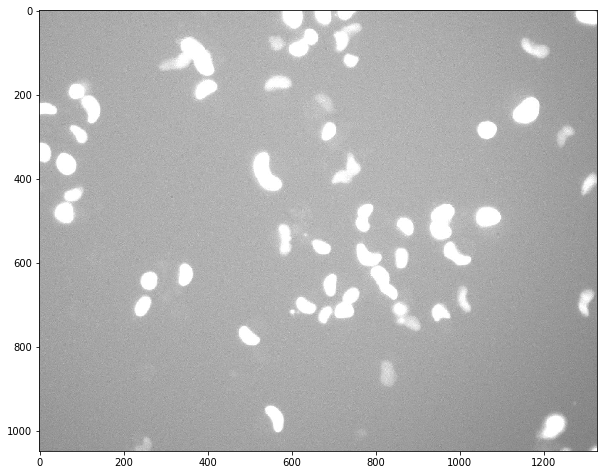

upload/valid/p180_0_A04F00d2.jpg


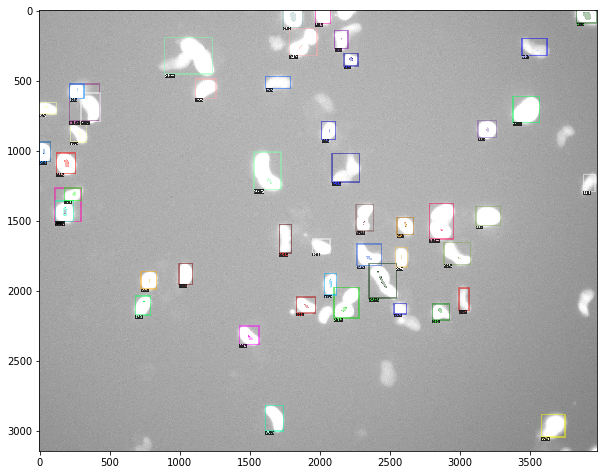

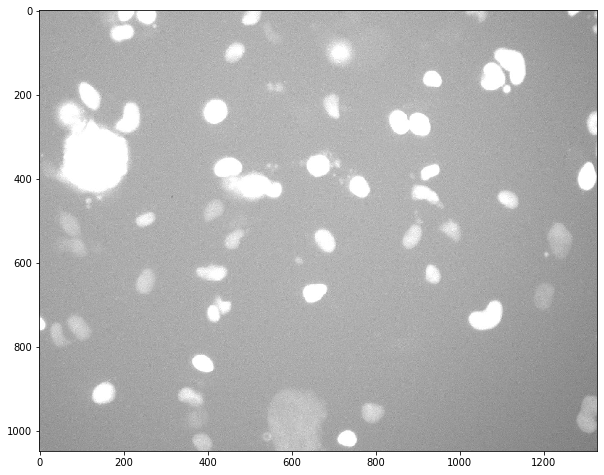

upload/valid/p310_0_A01F00d2.jpg


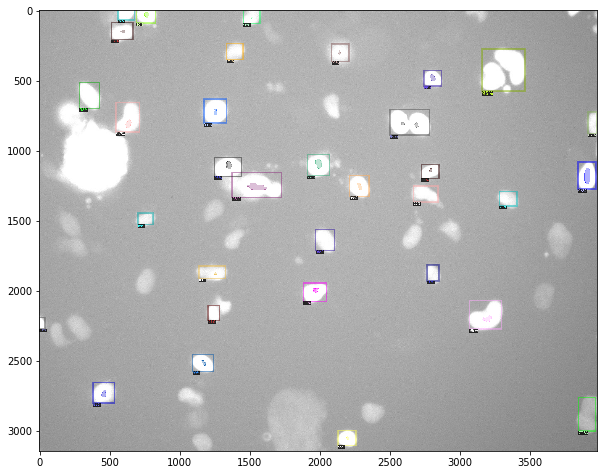

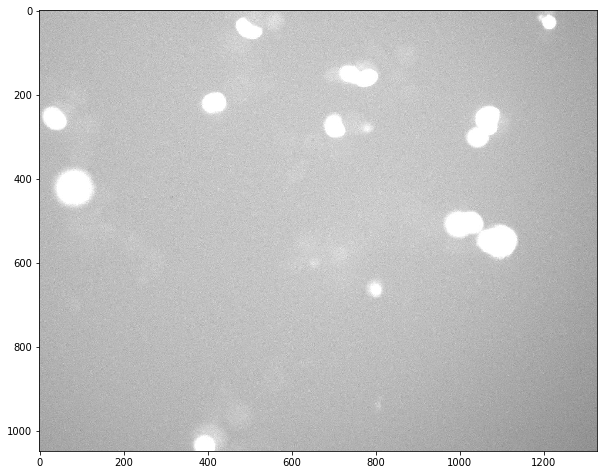

upload/valid/p492_0_A04F00d2.jpg


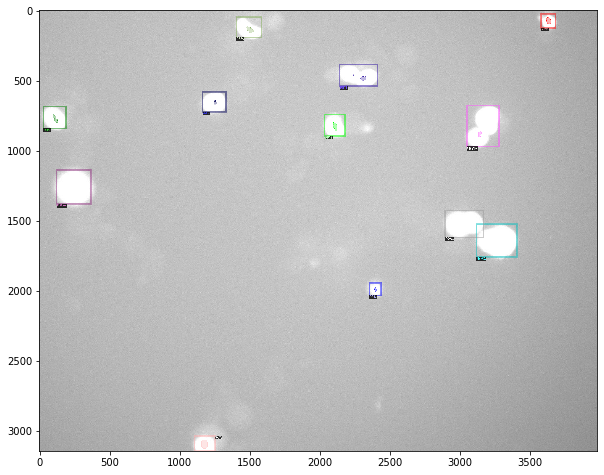

In [22]:
%pylab inline
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_cell_dicts(valid_dir)
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    fig = plt.figure(figsize=(10,10))
    imgplot = plt.imshow(im)
    plt.show()
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=cell_metadata, 
                   scale=3, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    #print(outputs["instances"].get_fields()) #['pred_masks'])
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    print(d["file_name"])
    fig = plt.figure(figsize=(10,10))
    imgplot = plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()